In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline

df = pd.read_csv('./listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


# Price per Neighbourhood?

We will be looking into which neighbourhoods in Seattle are the most expensive to stay in.

In [104]:
# Remove $ signs from all price columns and convert to floats.
def convert_currency_to_float(df, cols):
    """
    Removes $ sign from a list of column names, and converts the type to a float
     
    Parameters: 
    df -- pandas.dataframe that contains columns that require converting to float
    cols -- List of column names within df that need converting to float
    """
    for col in cols:
        df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)


In [105]:
convert_currency_to_float(df, ['price', 'weekly_price', 'monthly_price', 'security_deposit',
                           'cleaning_fee', 'extra_people'])

In [106]:
# Drop any rows where guests included > accomodates as this is clearly an error. We have no way of verifying which value 
# is incorrect, so we shuld remove the entry entirely
df.drop(df.loc[df['guests_included'] > df['accommodates']].index, inplace = True)

# If guests_included = 0 then assume listing is incorrect, or if there is no price for extra_people
# assume that price is for full occupancy, and replace guests_included value with 'accomodates' value
df.loc[(df['guests_included'] == 0) | (df['extra_people'] == 0),'guests_included'] = df['accommodates']

# Calculate price for full occupancy
df.loc[df['accommodates'] != df['guests_included'], 
       'fully_occupied_price'] = ((df['accommodates']-df['guests_included'])*df['extra_people']) + df['price']

# Fill NaN values in fully_occupied_price with price, as any rows with NaN will be because guests_included == accomodates, 
# so the price is already for fully occupied
df['fully_occupied_price'].fillna(value = df['price'], inplace = True)

# Add price per guest columns
df['price_per_included_guest'] = (df['price'] / df['guests_included'])
df['fully_occupied_price_per_guest'] = (df['fully_occupied_price'] / df['accommodates'])

In [107]:
df.loc[df['guests_included'] > df['accommodates']]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,fully_occupied_price,price_per_included_guest,fully_occupied_price_per_guest


In [108]:
# A bit of styling for visualisations
rcParams['figure.figsize'] = 10,6
base_color = sns.color_palette()[2]
second_color = sns.color_palette()[0]

In [109]:
def display_mean(df, group_col, value, color):
    """
    Displays a bar chart showing the average value per group
    
    Parameters: 
    df -- pandas.dataframe that contains columns to be displayed
    group_col -- name of the column to be grouped by
    value -- name of column to have mean average calculated
    color -- color of the bars in the visualisation
    """
    display_data = df[[group_col, value]]
    display_data = display_data.groupby([group_col]).mean().sort_values(by = value, ascending = False)
    display_data[group_col] = display_data.index
    sns.barplot(data = display_data, y = group_col, x = value, color = color);

## Standard Price

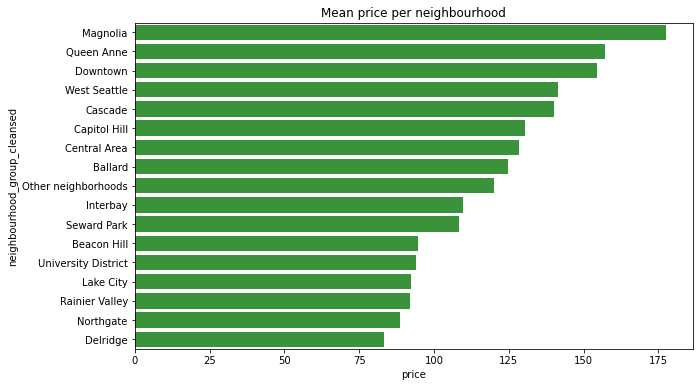

In [110]:
display_mean(df, 'neighbourhood_group_cleansed', 'price', base_color)
plt.title('Mean price per neighbourhood');


## Price per guest

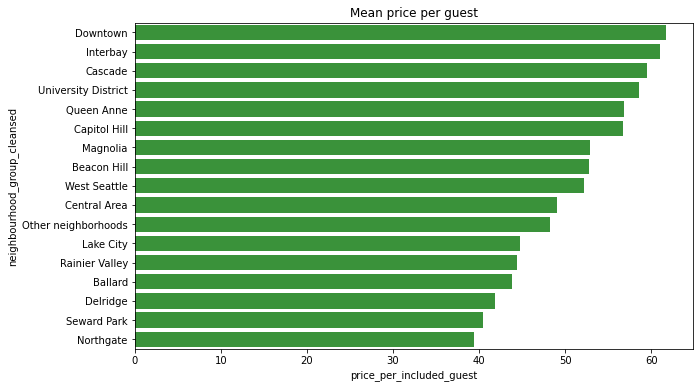

In [111]:
display_mean(df, 'neighbourhood_group_cleansed', 'price_per_included_guest', base_color)
plt.title('Mean price per guest');

## Price if fully occupied

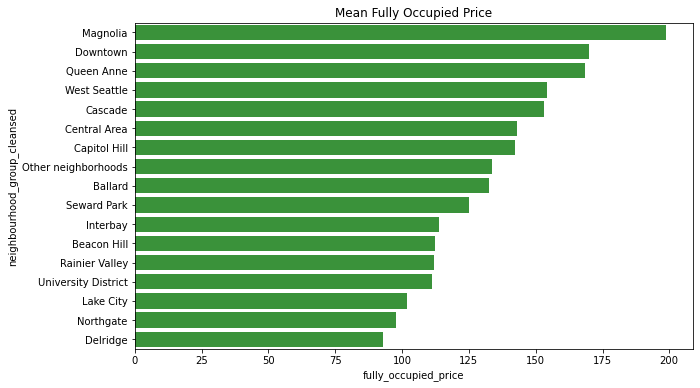

In [112]:
display_mean(df, 'neighbourhood_group_cleansed', 'fully_occupied_price', base_color)
plt.title('Mean Fully Occupied Price');

## Price per guest if fully occupied

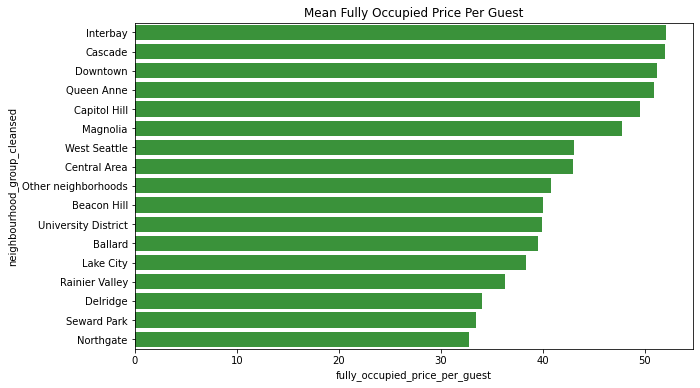

In [113]:
display_mean(df, 'neighbourhood_group_cleansed', 'fully_occupied_price_per_guest', base_color)
plt.title('Mean Fully Occupied Price Per Guest');

The above show us that there is potentially more earning potential in the 'Magnolia' neighbourhood, however this would appear to be based on being able to fit more guests in a property there, both as the standard offering and as the full occupancy. For smaller properties(fewer guests) the Interbay, Downtown and Cascade neighbourhoods offer the greater earning potential. We can verify this assumption by looking at the average number of guests and bedrooms per neighbourhood

## Number of bedrooms

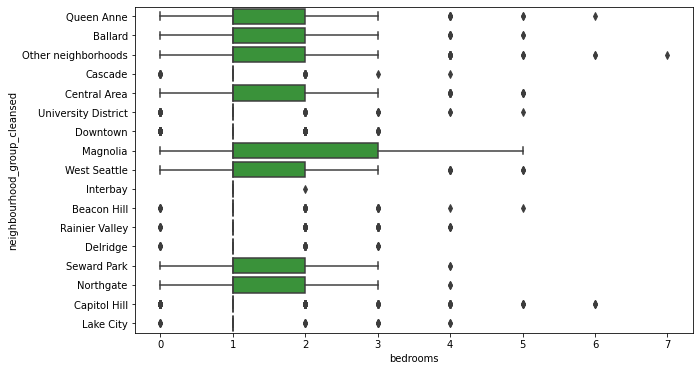

In [114]:
order = df.groupby(by=['neighbourhood_group_cleansed'])['bedrooms'].median().sort_values(ascending = False).index
sns.boxplot(data = df, y = 'neighbourhood_group_cleansed', x = 'bedrooms', color = base_color);

## Full Occupancy

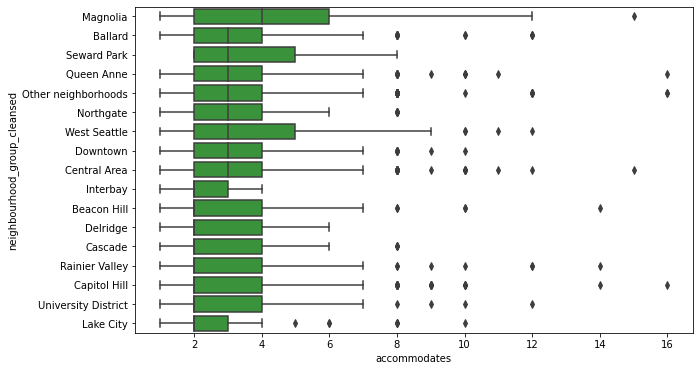

In [115]:
order = df.groupby(by=['neighbourhood_group_cleansed'])['accommodates'].median().sort_values(ascending = False).index
sns.boxplot(data = df, y = 'neighbourhood_group_cleansed', x = 'accommodates', color = base_color, order = order);

## Included Guests

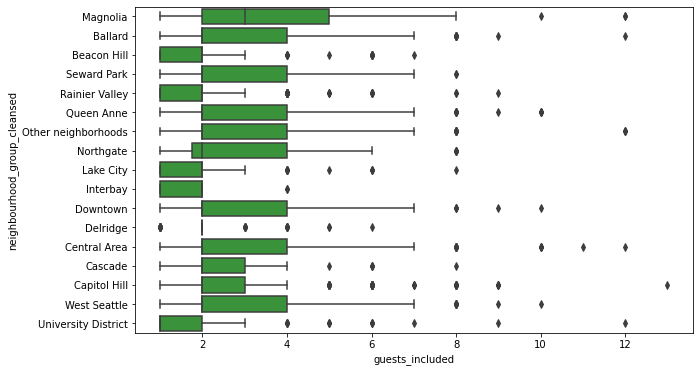

In [116]:
order = df.groupby(by=['neighbourhood_group_cleansed'])['guests_included'].median().sort_values(ascending = False).index
sns.boxplot(data = df, y = 'neighbourhood_group_cleansed', x = 'guests_included', color = base_color, order = order);

The price visualisations above are all based on a mean average, we should take a look at some box plots to help us spot any other patterns we may have missed, or to verify our findings based on the mean.

## Standard Price

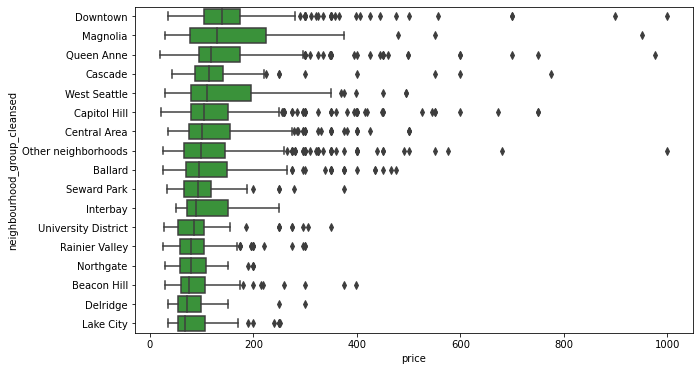

In [117]:
order = df.groupby(by=['neighbourhood_group_cleansed'])['price'].median().sort_values(ascending = False).index
sns.boxplot(data = df, y = 'neighbourhood_group_cleansed', x = 'price', color = base_color, order = order);

## Price per guest

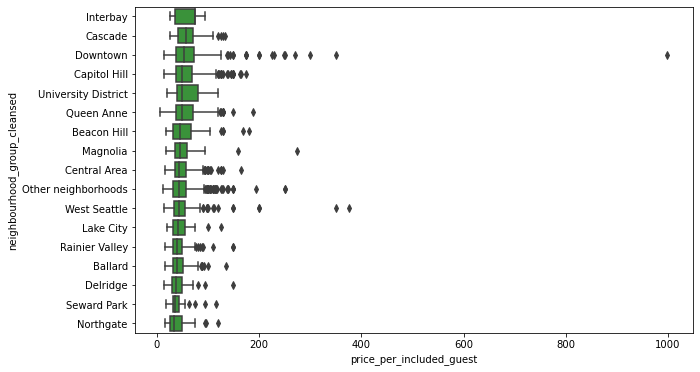

In [118]:
order = df.groupby(by=['neighbourhood_group_cleansed'])['price_per_included_guest'].median().sort_values(ascending = False).index
sns.boxplot(data = df, y = 'neighbourhood_group_cleansed', x = 'price_per_included_guest', color = base_color, order = order);

## Fully Occupied Price

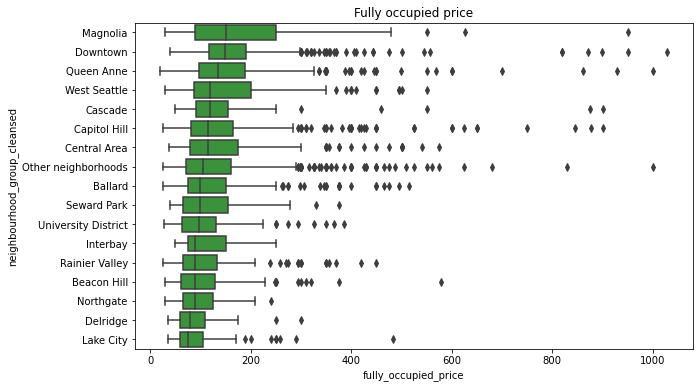

In [119]:
order = df.groupby(by=['neighbourhood_group_cleansed'])['fully_occupied_price'].median().sort_values(ascending = False).index
sns.boxplot(data = df, y = 'neighbourhood_group_cleansed', x = 'fully_occupied_price', color = base_color, order = order);
plt.title('Fully occupied price');

## Fully Occupied Price Per Guest

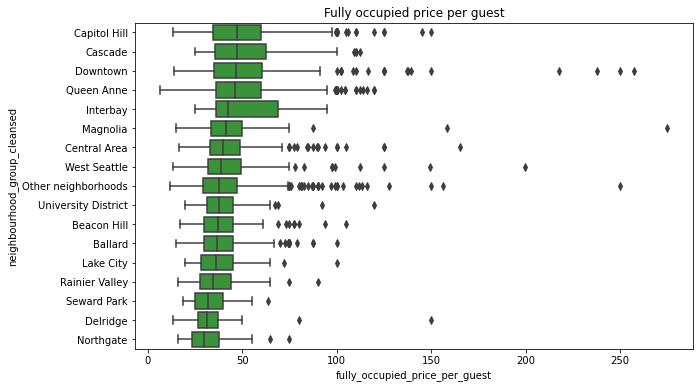

In [120]:
order = df.groupby(by=['neighbourhood_group_cleansed'])['fully_occupied_price_per_guest'].median().sort_values(ascending = False).index
sns.boxplot(data = df, y = 'neighbourhood_group_cleansed', x = 'fully_occupied_price_per_guest', color = base_color, order = order);
plt.title('Fully occupied price per guest');

The boxplots support our finding that 'Magnolia' appears to offer the greater earning potential, but this is based on accomodating more guests, as when you look at the per guest price it does not appear as high as other neighbourhoods. When looking at a per guest price, 'Interbay', 'Cascade' and 'Downtown' still score highly, with 'Interbay' having the highest upper quartile, despite the median being only 5th highest.

# Demand per neighbourhood?

Because we know that the 'Magnolia' neighbourhood offers the higher earning potential, if it can attract more guests, we should take a look at the demand for each neighbourhood. This will give an indication as to whether the listings in 'Magnolia' are likely to be filled, or if the properties that make a higher earning per guest would meet the demand.

In [121]:
# Calculate how many nights each property is booked for in the next 30 days. The other availability columns are not
# particularly relevant to this question, as we are only interested in how many nights are being booked, not how far
# in advance those bookings are made.

df['booked_30'] = 30-df['availability_30']

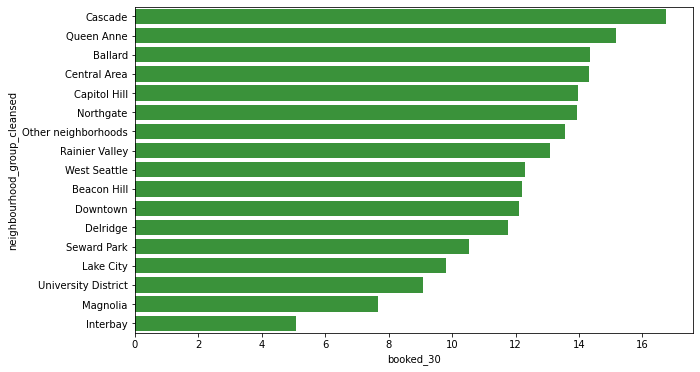

In [122]:
display_mean(df, 'neighbourhood_group_cleansed', 'booked_30', base_color)

Text(0.5, 1.0, 'Nights booked in next 30 days per neighbourhood')

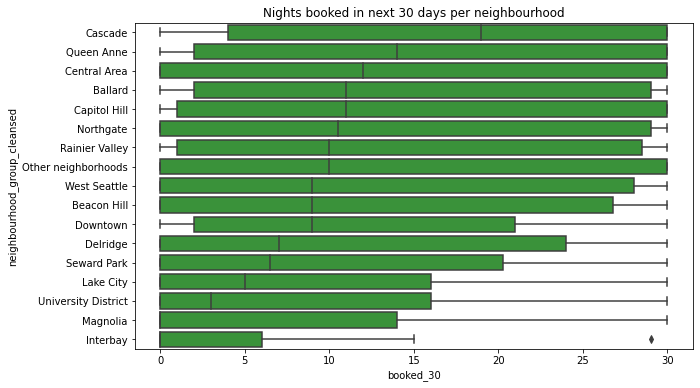

In [123]:
order = df.groupby(by=['neighbourhood_group_cleansed'])['booked_30'].median().sort_values(ascending = False).index
sns.boxplot(data = df, y = 'neighbourhood_group_cleansed', x = 'booked_30', color = base_color, order = order);
plt.title('Nights booked in next 30 days per neighbourhood')

The 2 visualisations above show us that 'Cascade' is the neighbourhood with the highest demand in terms of mean, median and having the highest lower quartile. 'Magnolia' and 'Interbay' have comparitively very low booking rates.

Looking at these 2 findings together, Cascade seems to make most sense for our investment

# Impact on price and demand

There were a large number of outliers when we looked at the prices per neighbourhood, this might indicate that there are other factors to consider when calculating the price of a listing. I also want to know if these amenities generate the highest demand for a property.

We will now investigate which amenities have the highest impact on a listing price and demand.

Due to the way it is populated we can not use get_dummies to get the dummies for the amenities column, we will need to create our own function to perform this.

In [124]:
def create_dummy_cols(df, col, keep_original = False):
    """
    Splits a dataframe column containing multiple categorical values per row, into dummy columns for each
    unique categorical value. Columns are named in the format '[original_name]_[category_name]' in all lower case
    and are of type int.
     
    Parameters: 
    df -- pandas.dataframe that contains columns that require converting to float.
    col -- column name to split.
    keep_original -- default is False, this will remove the col to split from the dataframe.
    """
    
    for dummy_col in split_column_to_unique_list(df, col):
        df['{}_{}'.format(col, dummy_col.replace(' ', '_').lower())] = df[col].str.contains(dummy_col).astype(int)
        
    if keep_original == False:
        df.drop(columns = col, inplace = True)

In [125]:
def split_column_to_unique_list(df, col):
    """
    Splits a dataframe column containing multiple categorical values per row, and returns
    a list of distinct values within that column
     
    Parameters: 
    df -- pandas.dataframe that contains columns that require splitting
    col -- column name to split
    """
    result = list()
    # Loop through all rows in column
    for row in df[col].tolist():
        # Split each row by commas, and remove undesireable chars
        for value in row.replace('{','').replace('}', '').replace('"', '').split(','):
                if(len(value) > 0):
                    # Add individual value to result list
                    result.append(value)

    # Create a list of unique values
    return list(set(result))




In [126]:
# Create dummies for amenities column
dummy_df = df.copy()
create_dummy_cols(dummy_df, 'amenities')

C:\Users\david.bracken\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [127]:
# Get list of all dummy columns we want to check
dummy_cols = [col for col in dummy_df if col.startswith('amenities')]
dummy_cols += ['price', 'booked_30']

In [141]:
lm_df = dummy_df[dummy_cols]
lm_df = lm_df[lm_df.columns[lm_df[dummy_cols].sum() > 250]]

In [142]:
X = lm_df.drop(['price', 'booked_30'], axis = 1)
y = lm_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=46)

price_model = LinearRegression(normalize=True) 
price_model.fit(X_train, y_train)

y_test_preds = price_model.predict(X_test)
y_train_preds = price_model.predict(X_train)

test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print("The rsquared on the price training data was {}.  The rsquared on the price test data was {}.".format(train_score, test_score))


The rsquared on the price training data was 0.16286459966964495.  The rsquared on the price test data was 0.16969101261500696.


In [143]:
X = lm_df.drop(['price', 'booked_30'], axis = 1)
y = lm_df['booked_30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=46)

demand_model = LinearRegression(normalize=True) 
demand_model.fit(X_train, y_train)

y_test_preds = demand_model.predict(X_test)
y_train_preds = demand_model.predict(X_train)

test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print("The rsquared on the training data for demand was {}.  The rsquared on the test data for demand was {}.".format(train_score, test_score))


The rsquared on the training data for demand was 0.032508475616153776.  The rsquared on the test data for demand was 0.011144248854576766.


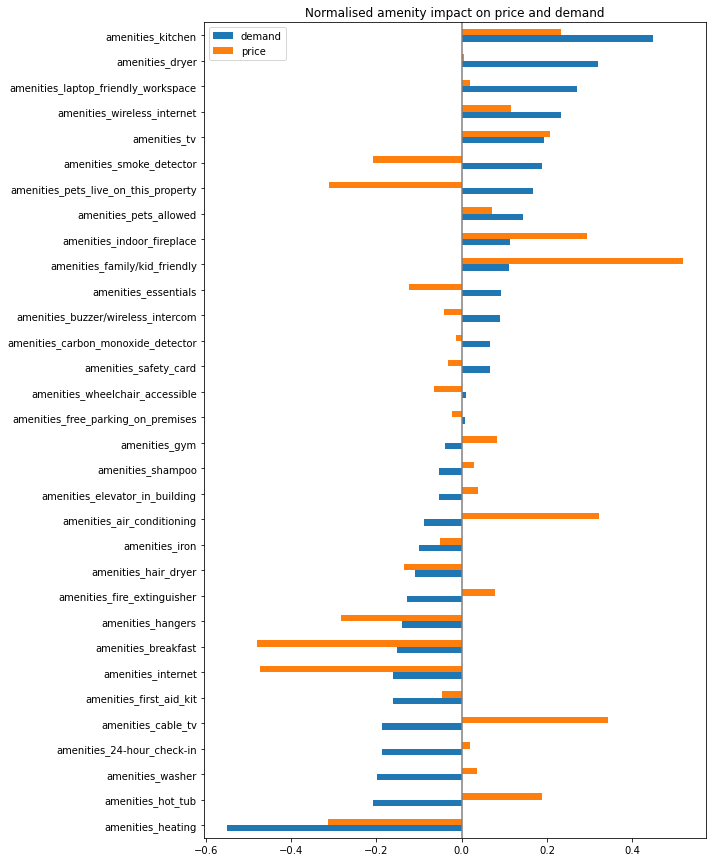

In [148]:
coefs_df = pd.DataFrame({'demand': demand_model.coef_,
                         'price': price_model.coef_},
                       index = X_train.columns)
coefs_df = coefs_df.sort_values('demand')
# Normalise the data
coefs_df = (coefs_df - coefs_df.mean()) / (coefs_df.max() - coefs_df.min())
coefs_df.plot(kind='barh', figsize = (9, 15));
plt.axvline(x=0, color='.5');
plt.title('Normalised amenity impact on price and demand');

Although the model wasn't very accurate, with an rsquared of just 0.17 on the test data and 0.01 for demand, there is still an indication of which amenities have the highest impact on price and demand.

The model was never going to score too highly based on just the amenities, as it didn't consider things such as neighbourhood, house type, room type etc. It is reasonable to expect all of these other variables to have a significant impact on the overall result. However the intention was specifically to investigate which amenities had the greatest impact, so these are the only variables that were relevant to the model.